In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import recall_score, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
df = pd.read_csv("../data/in-vehicle_coupon_recommendation.csv")

**EDA**

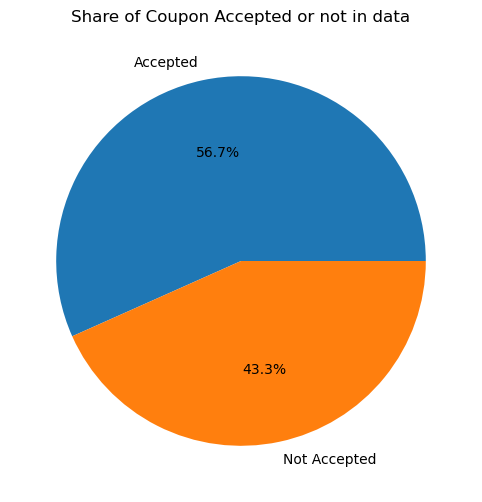

In [8]:
# simple script to make a pie plot showing share of classes
plt.figure(figsize=(10,6))
plt.pie(df.Y.value_counts(),labels=['Accepted','Not Accepted'], autopct='%.1f%%')
plt.title("Share of Coupon Accepted or not in data")
plt.savefig('../eda/share_of_classes.png')
plt.show()

In [9]:
ordinal_columns = ['temperature','expiration','age','income'] 

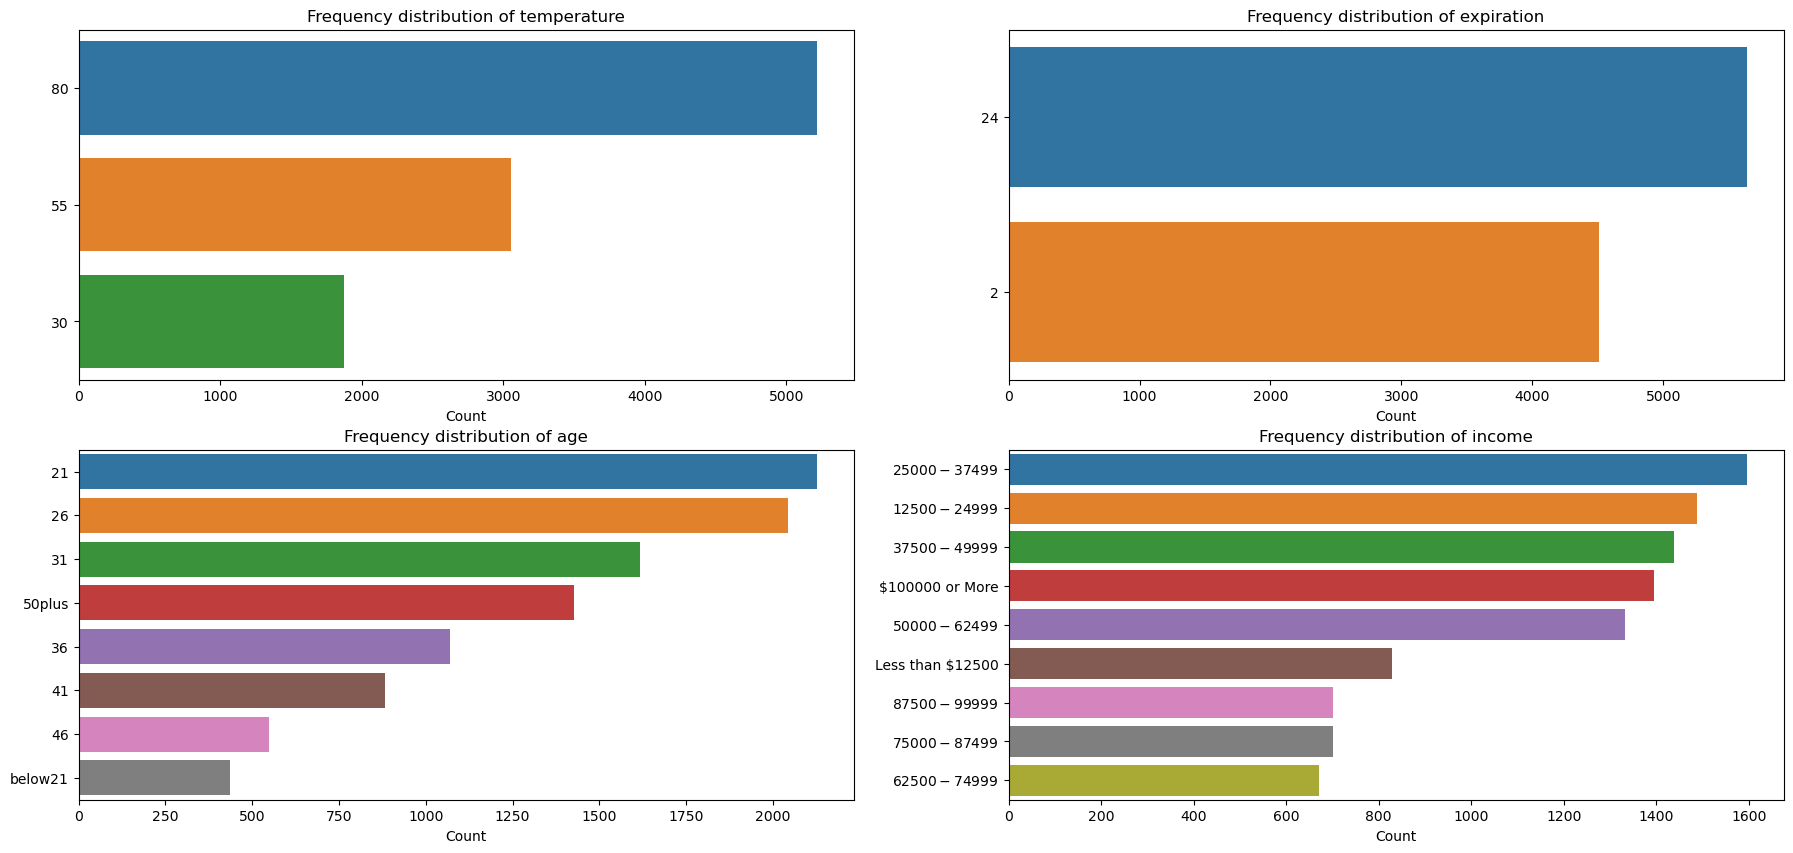

In [10]:
def freq_plotter(nrows, ncols,figsize,cols_to_plot):
    '''
    Helper function to print countplots / frequency-distribution of each attribute
    '''
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=figsize)
    ax = ax.flatten()
    i = 0
    for col in df.columns:
        if col in cols_to_plot and col!='Y':  # we don't want to see distribution of target variable
            if df[col].dtype==np.int64:   # Any numeric column is converted to categorical first for plotting countplots
                df[col] = df[col].astype(str)
            temp = df[col].value_counts()
            sns.barplot(x=temp.values,y=temp.index,ax=ax[i])
            ax[i].set_xlabel('Count')
            ax[i].set_title('Frequency distribution of {}'.format(col))
            plt.savefig('../eda/freq_distribution.png')
            i += 1
freq_plotter(nrows=2, ncols=2,figsize=(22,10),cols_to_plot=ordinal_columns)

In [11]:
temp = df.copy()

In [12]:
def plot_bivariate(f1,f2,temp,rotate_ticks=False,deg=90, fig_name=None):
    '''
    Helper function to see if any bivariate relatonships in data are helping us detect any trends in categorical data
    '''

    temp['feature_comb'] = temp[f1].astype('str') + ' & ' + temp[f2].astype('str') 
    sns.countplot(x='feature_comb',hue='Y',data=temp)
    plt.xlabel("Combination of {} & {}".format(f1,f2))
    plt.title("Effect of {} & {} on target variable".format(f1,f2))
    plt.ylabel("")
    if rotate_ticks:
        plt.xticks(rotation=deg)
    plt.legend(labels=['Rejected','Accepted'])
    plt.show()

    if fig_name is not None:
        plt.savefig('../eda/' + fig_name + '.png')
    else:
        plt.savefig('../eda/bivariate_weather_temp.png')


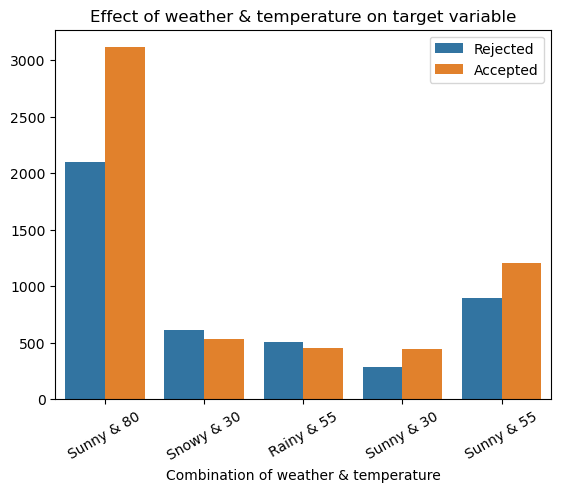

<Figure size 640x480 with 0 Axes>

In [13]:
plot_bivariate('weather', 'temperature',temp,rotate_ticks=True,deg=30,fig_name='bivariate_weather_temp')

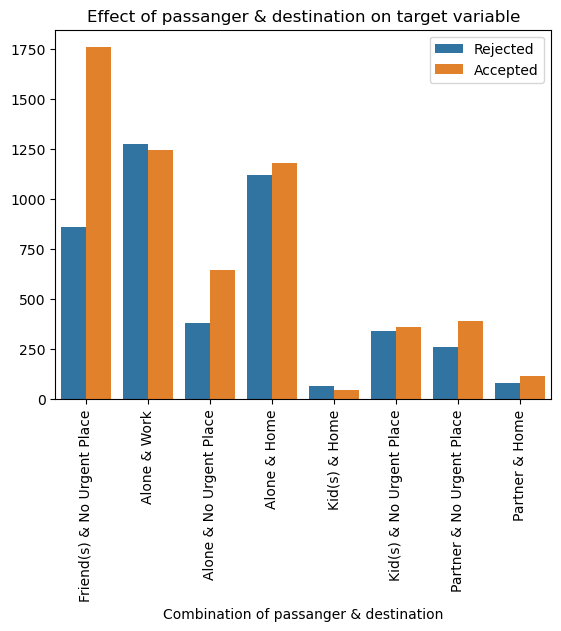

<Figure size 640x480 with 0 Axes>

In [14]:
plot_bivariate('passanger', 'destination',temp,rotate_ticks=True,deg=90,fig_name='bivariate_passanger_destination')

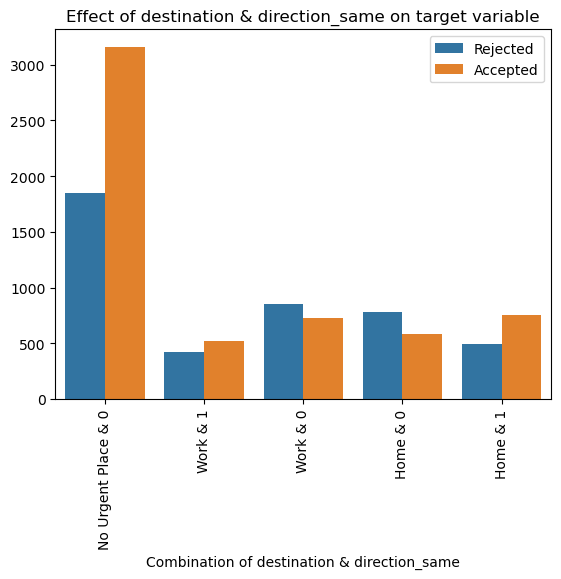

<Figure size 640x480 with 0 Axes>

In [15]:
plot_bivariate('destination', 'direction_same',temp,rotate_ticks=True,deg=90,fig_name='bivariate_destination_direction')

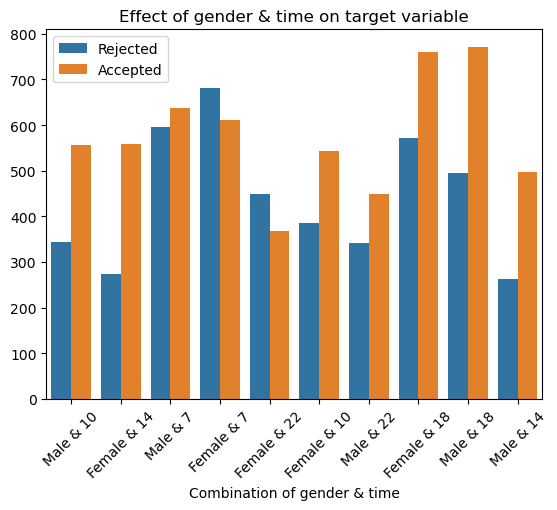

<Figure size 640x480 with 0 Axes>

In [16]:
plot_bivariate('gender', 'time',temp,rotate_ticks=True,deg=45,fig_name='bivariate_gender_time')

**Test and training set split and minimal data preparation**

In [7]:
# for data preprocessing I want to use one-hot encoding for Nominal and ordinal attributes and scaling for interval attributes 
# (there are no ratio attributes available)
# time plays a special role as it needs to be converted to 0-24 first!!!
# same for expiration
# has children, toCoupon_GEQ5min, toCoupon_GEQ15min, toCoupon_GEQ25min, direction_same,
# direction_opp, Y, are already in the required format

OneHot = ['destination','passanger','weather','coupon','gender','age','maritalStatus','education','occupation','income','car','Bar','CoffeeHouse',
         'CarryAway','RestaurantLessThan20','Restaurant20To50']

OneHotPref = ['destination_','passanger_','weather_','coupon_','gender_','age_','maritalStatus_','education_','occupation_','income_','car_','Bar_','CoffeeHouse_',
         'CarryAway_','RestaurantLessThan20_','Restaurant20To50_']

Interval = ['temperature','time','expiration']

df=df.replace(['6PM','7AM','10AM','2PM','10PM'],[18,7,10,14,22]) # this converts times of the day to the format 0-24 to make things comparable
df=df.replace(['1d','2h'],[24,2]) # this replaces the expiration time with hours to make it comparable

# next I split target and other attributes as well as test and training set

 # split the data into training and test sets

df_train, df_TEST = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)
df = df_train # Note that I call the training set df again, because I will do k-fold cross validation etc on this set

df_train.to_csv('../data/in-vehicle_train.csv', index=False)
df_TEST.to_csv('../data/in-vehicle_test.csv', index=False)


**Print useful information on data set**

In [4]:
df.describe();
df.dtypes; # Show name of all columns and type
df['car'].value_counts(); # show e.g. 'car' / Bar' column which possible outcomes occurr how frequently
df.isna().sum();# show total missing values
df.isna().sum()/len(df)*100; # show percentage of missing values
df.head(10);

#pd.set_option('display.max_rows', None) # can be used to display arbitrarily many rows etc
#pd.set_option('display.max_columns', None)

**Missing Values + One hot encoding**

In [5]:
# the whole procedure is encoded to the function f below. The test and training set have to be provided to f
# if the option most frequent is chosen, missing values are replaced by the most frequent value
# if the option OwnCategory is chosen, missing values are an own category
# in either case one hot encoding is used for non numeric values
seed = 1

def f(Choose, df_train, df_test):
    [car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50]=[df_train['car'].mode()[0],df_train['Bar'].mode()[0],df_train['CoffeeHouse'].mode()[0],
                      df_train['CarryAway'].mode()[0], df_train['RestaurantLessThan20'].mode()[0],df_train['Restaurant20To50'].mode()[0]] # the .mode()[0] function returns the most frequent value in the car colum 
    
    if Choose == 'MostFrequent':
        #fillna replaces all missing values with the specified value
        df_train['car'].fillna(car, inplace=True)
        df_train['Bar'].fillna(Bar, inplace=True)
        df_train['CoffeeHouse'].fillna(CoffeeHouse, inplace=True)
        df_train['CarryAway'].fillna(CarryAway, inplace=True)
        df_train['RestaurantLessThan20'].fillna(RestaurantLessThan20, inplace=True)
        df_train['Restaurant20To50'].fillna(Restaurant20To50, inplace=True)

        df_test['car'].fillna(car, inplace=True)
        df_test['Bar'].fillna(Bar, inplace=True)
        df_test['CoffeeHouse'].fillna(CoffeeHouse, inplace=True)
        df_test['CarryAway'].fillna(CarryAway, inplace=True)
        df_test['RestaurantLessThan20'].fillna(RestaurantLessThan20, inplace=True)
        df_test['Restaurant20To50'].fillna(Restaurant20To50, inplace=True)

        #get_dummies applies one hot encoding
        df_train=pd.get_dummies(df_train, columns=OneHot,prefix=OneHotPref, prefix_sep='', dummy_na=True)
        df_test=pd.get_dummies(df_test, columns=OneHot,prefix=OneHotPref, prefix_sep='', dummy_na=True)
        
        # ensure that shapes are consistent after one-hot encoding. If one possible value of car e.g.
        #is missing in the test set, the number of columns will differ after one hot encoding with the training set
        # without the align method
        df_train, df_test = df_train.align(df_test, join='outer', axis=1, fill_value=0)
        
    
    elif Choose == 'OwnCategory':
        # note that get_dummies automatically encodes missing values with (0,0,..0) they hence are their
        # own category without additional work
        df_train=pd.get_dummies(df_train, columns=OneHot,prefix=OneHotPref, prefix_sep='', dummy_na=True)
        df_test=pd.get_dummies(df_test, columns=OneHot,prefix=OneHotPref, prefix_sep='', dummy_na=True)
        df_train, df_test = df_train.align(df_test, join='outer', axis=1, fill_value=0)
        
    else:
        print("Invalid input argument. You can choose between 'MostFrequent' and 'OwnCategory'")
        
    if df_train.shape[1] != df_test.shape[1]:
        print("Inconsistent shapes after one hot encoding.")
        return None    
        
    return df_train, df_test   

**Scaling function**

In [5]:
#The following function takes the training, validation and test set as input, as well as the option
# 'minMax' or 'normalize' and returns the data sets in scaled form using either minmax scaling or
# normalizatin. The scaling parameters are taken from the test set first and then applied to the validation and test set

def scale(df_train, df_test,Option):
    if Option == 'minMax':
        scaler_minmax = MinMaxScaler()
        df_train[Interval] = scaler_minmax.fit_transform(df_train[Interval])
        df_test[Interval] = scaler_minmax.transform(df_test[Interval])
    elif Option == 'normalize':
        scaler_norm = StandardScaler()
        df_train[Interval] = scaler_norm.fit_transform(df_train[Interval])
        df_test[Interval] = scaler_norm.transform(df_test[Interval])
    elif Option == 'None':
        df_train=df_train
        df_test=df_test
        
    else:
        print("Invalid option. 'minMax', 'normalize' and 'None' are allowed. ")
        
    return df_train, df_test

**Train neural network k-fold cross validation**

In [6]:
# the KFOLD function does a kfold cross validation and returns the averaged accuracy and recall + standard deviation over
# all folds, as well as the trivial baseline (put in majority class) as comparison
seed = 1
def KFOLD(k, N1, MissingVal, Scaling, layers): 
    df_input = df.drop('Y', axis=1) # input values 
    df_output = df['Y'] # output

    # define the k-fold cross validation object
    kfold = KFold(n_splits=k, shuffle=True, random_state=seed)

    # perform the k-fold cross validation and get the results
    scores_mse = []
    scores_mae = []
    scores_recall = []
    scores_accuracy = []
    baseline_recall = []
    baseline_accuracy = []

    for train_index, test_index in kfold.split(df_input):
        # split the data into training and test sets for this fold
        df_input_train_fold, df_input_test_fold = df_input.iloc[train_index].copy(), df_input.iloc[test_index].copy()
        df_output_train_fold, df_output_test_fold = df_output.iloc[train_index], df_output.iloc[test_index]

        # compute baseline recall and accuracy
        majority_class = df_output_train_fold.mode()[0]
        baseline_recall_fold = recall_score(df_output_test_fold, [majority_class] * len(df_output_test_fold))
        baseline_accuracy_fold = accuracy_score(df_output_test_fold, [majority_class] * len(df_output_test_fold))
        baseline_recall.append(baseline_recall_fold)
        baseline_accuracy.append(baseline_accuracy_fold)

        # data preparation
        df_input_train_fold, df_input_test_fold = f(MissingVal, df_input_train_fold, df_input_test_fold)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
        df_input_train_fold, df_input_test_fold = scale(df_input_train_fold, df_input_test_fold,Scaling) # choose 'minMax' or 'normalize' scalinig

        #define model
        model = Sequential() # linear stack of layers where you can add as many layers as you want
        model.add(Dense(N1, input_dim=df_input_train_fold.shape[1], activation='relu')) #add lay ofer 64 neurons
        if layers == 2:
             model.add(Dense(N1, input_dim=N1, activation='relu')) #add lay ofer 64 neurons
        
        model.add(Dense(1, activation='sigmoid')) # sigmoid ensures that the ourput is between 0 and 1. This can be seen as probablities

        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

        # train the model on the training set for this fold
        model.fit(df_input_train_fold, df_output_train_fold, epochs=100, batch_size=32, verbose=0)

        # evaluate the model on the test set for this fold
        Y_pred_fold = model.predict(df_input_test_fold)
        Y_pred_fold = np.round(Y_pred_fold) # round the predicted values to 0 or 1

        mse = mean_squared_error(df_output_test_fold, Y_pred_fold)
        mae = mean_absolute_error(df_output_test_fold, Y_pred_fold)
        recall = recall_score(df_output_test_fold, Y_pred_fold)
        accuracy = accuracy_score(df_output_test_fold, Y_pred_fold)
        scores_mse.append(mse)
        scores_mae.append(mae)
        scores_recall.append(recall)
        scores_accuracy.append(accuracy)
    return (np.mean(scores_recall), np.std(scores_recall)), (np.mean(scores_accuracy), np.std(scores_accuracy)), (np.mean(baseline_recall), np.std(baseline_recall)), (np.mean(baseline_accuracy), np.std(baseline_accuracy))



**Train neural network holdout**

In [7]:
seed = 1
def HoldOUT(test_frac, N1, MissingVal, Scaling, layers):
    df_input = df.drop('Y', axis=1) # input values 
    df_output = df['Y'] # output

    # split the data into training and test sets
    df_input_train, df_input_test, df_output_train, df_output_test = train_test_split(df_input, df_output, test_size=test_frac, random_state=seed, shuffle=True)


    # compute baseline recall and accuracy
    majority_class = df_output_train.mode()[0]
    baseline_recall = recall_score(df_output_test, [majority_class] * len(df_output_test))
    baseline_accuracy = accuracy_score(df_output_test, [majority_class] * len(df_output_test))

    # data preparation
    df_input_train, df_input_test = f(MissingVal, df_input_train, df_input_test)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
    df_input_train, df_input_test = scale(df_input_train, df_input_test, Scaling) # choose 'minMax' or 'normalize' scalinig

    model = Sequential() # linear stack of layers where you can add as many layers as you want
    model.add(Dense(N1, input_dim=df_input_train.shape[1], activation='relu')) #add lay ofer 64 neurons
    if layers == 2:
             model.add(Dense(N1, input_dim=N1, activation='relu')) #add lay ofer 64 neurons
    model.add(Dense(1, activation='sigmoid')) # sigmoid ensures that the ourput is between 0 and 1. This can be seen as probablities

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    # train the model on the training set
    model.fit(df_input_train, df_output_train, epochs=100, batch_size=32, verbose=0)

    # evaluate the model on the test set
    Y_pred = model.predict(df_input_test)
    Y_pred = np.round(Y_pred) # round the predicted values to 0 or 1

    mse = mean_squared_error(df_output_test, Y_pred)
    mae = mean_absolute_error(df_output_test, Y_pred)
    recall = recall_score(df_output_test, Y_pred)
    accuracy = accuracy_score(df_output_test, Y_pred)
    
    return recall, accuracy, baseline_recall, baseline_accuracy


**Optimize NN based on k-fold cross validation first for N1 one hidden layer**

In [8]:
# the results here have been optained from running the above cells for different parameters
# first parameter k = 4 is kept fixed and I optimize accuracy and recall for N1
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]

k=4
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'
layers = 1

N1 = [1,10,50,100,200]
Accuracy = []
AccuracyStd = []
Recall = []
RecallStd = []
AccuracyBaseline = []
RecallBaseline = []

for N in N1:
    RecallA, AccuracyA, RecallBaselineA, AccuracyBaselineA = KFOLD(k, N, MissingVal, Scaling, layers)
    Accuracy.append(AccuracyA[0])
    AccuracyStd.append(AccuracyA[1])
    Recall.append(RecallA[0])
    RecallStd.append(RecallA[1])
    AccuracyBaseline.append(AccuracyBaselineA[0])
    RecallBaseline.append(RecallBaselineA[0])
    
print('Accuracy:')
print(Accuracy)
print('Accuracy Std:')
print(AccuracyStd)
print('Recall:')
print(Recall)
print('RecallStd')
print(RecallStd)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

80/80 [==============================] - 0s 1ms/step
Accuracy:
[0.6852262772792327, 0.7161711325381204, 0.7194236653987857, 0.7221856663338426, 0.7305609627357382]
Accuracy Std:
[0.006391230697383945, 0.006960121374943564, 0.007923877156185335, 0.018341470386421987, 0.005759796518125554]
Recall:
[0.7672261083909309, 0.7641274393671861, 0.7725054982482455, 0.7636321236123379, 0.7702258332202208]
RecallStd
[0.011164370367588265, 0.017372287075874304, 0.021922102034513384, 0.01116520666096132, 0.021334862721862573]
AccuracyBaseline
[0.5667680240951272, 0.5667680240951272, 0.5667680240951272, 0.5667680240951272, 0.5667680240951272]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0]


**Optimize NN based on k-fold cross validation first for N1 two hidden layer**

In [9]:
# the results here have been optained from running the above cells for different parameters
# first parameter k = 4 is kept fixed and I optimize accuracy and recall for N1
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]

k=4
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'
layers = 2

N1 = [1,10,50,100,200]
Accuracy = []
AccuracyStd = []
Recall = []
RecallStd = []
AccuracyBaseline = []
RecallBaseline = []

for N in N1:
    RecallA, AccuracyA, RecallBaselineA, AccuracyBaselineA = KFOLD(k, N, MissingVal, Scaling, layers)
    Accuracy.append(AccuracyA[0])
    AccuracyStd.append(AccuracyA[1])
    Recall.append(RecallA[0])
    RecallStd.append(RecallA[1])
    AccuracyBaseline.append(AccuracyBaselineA[0])
    RecallBaseline.append(RecallBaselineA[0])
    
print('Accuracy:')
print(Accuracy)
print('Accuracy Std:')
print(AccuracyStd)
print('Recall:')
print(Recall)
print('RecallStd')
print(RecallStd)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

80/80 [==============================] - 0s 2ms/step
Accuracy:
[0.5667680240951272, 0.707696672838209, 0.7190301596311498, 0.7226756931172589, 0.7292796112798717]
Accuracy Std:
[0.00799258670679174, 0.010469017085646338, 0.009936741749649439, 0.009604904510297968, 0.003483408760950894]
Recall:
[1.0, 0.7635447503335555, 0.7729831192841238, 0.7671447172417496, 0.7734469280608622]
RecallStd
[0.0, 0.008147555842533235, 0.017883107825653513, 0.025241277997908113, 0.019931577516036122]
AccuracyBaseline
[0.5667680240951272, 0.5667680240951272, 0.5667680240951272, 0.5667680240951272, 0.5667680240951272]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0]


**Optimize NN k-fold based on k**

In [10]:
# from the above optimization, I saw that the architecture single HL and 100 Neurons reaches about optimal performance
# I take this as a starting value and optimize based on k = 2 - 5
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]
# the results here have been optained from running the above cells for different parameters
# first parameter k = 4 is kept fixed and I optimize accuracy and recall for N1
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'
layers = 1

k = [2,3,4,5]
Accuracy = []
AccuracyStd = []
Recall = []
RecallStd = []
AccuracyBaseline = []
RecallBaseline = []

for N in k:
    RecallA, AccuracyA, RecallBaselineA, AccuracyBaselineA = KFOLD(N, 100, MissingVal, Scaling, 1)
    Accuracy.append(AccuracyA[0])
    AccuracyStd.append(AccuracyA[1])
    Recall.append(RecallA[0])
    RecallStd.append(RecallA[1])
    AccuracyBaseline.append(AccuracyBaselineA[0])
    RecallBaseline.append(RecallBaselineA[0])
    
print('Accuracy:')
print(Accuracy)
print('Accuracy Std:')
print(AccuracyStd)
print('Recall:')
print(Recall)
print('RecallStd')
print(RecallStd)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

64/64 [==============================] - 0s 1ms/step
Accuracy:
[0.7164675011680082, 0.7221841632415041, 0.725436256339923, 0.7312497359712737]
Accuracy Std:
[0.004265648221034035, 0.010318564897030732, 0.003528834587081419, 0.009152277451739329]
Recall:
[0.7553084271076236, 0.7703035737208924, 0.7620334418595018, 0.775545485820022]
RecallStd
[0.005395992781879244, 0.04021525494014402, 0.010658703988338318, 0.01944769525006824]
AccuracyBaseline
[0.5667689067171523, 0.5667684557456406, 0.5667680240951272, 0.5667692838084232]
RecallBaseline
[1.0, 1.0, 1.0, 1.0]


 **Compare different data preps for final results k-Fold**

In [11]:
# from the above analysis we saw that one hidden layer with 100 neurons and k = 5 reaches about optimal performance
# lastly we will check what happens 
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]
k = 5
N1 = 100
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'None' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

RecallA, AccuracyA, RecallBaselineA, AccuracyBaselineA = KFOLD(k, N1, MissingVal, Scaling, 1)
Accuracy = AccuracyA[0]
AccuracyStd = AccuracyA[1]
Recall = RecallA[0]
RecallStd = RecallA[1]
AccuracyBaseline = AccuracyBaselineA[0]
RecallBaseline = RecallBaselineA[0]

print('Accuracy:')
print(Accuracy)
print('Accuracy Std:')
print(AccuracyStd)
print('Recall:')
print(Recall)
print('RecallStd')
print(RecallStd)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

64/64 [==============================] - 0s 1ms/step
Accuracy:
0.7181420632357904
Accuracy Std:
0.00826992727561729
Recall:
0.7702393383002176
RecallStd
0.03859113911247699
AccuracyBaseline
0.5667692838084232
RecallBaseline
1.0


**Optimize N1 with holdout one and two hidden layer**

In [12]:
# first I optimize N1 with holdout assuming testset of 0.2 fixed
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]
        
test_frac=0.2 #fraction of test set
layers = 1 # 1 or 2 hidden layers for NN
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

N1 = [1,10,50,100,200]
Accuracy = []
Recall = []
AccuracyBaseline = []
RecallBaseline = []

for N in N1:
    recall, accuracy, baseline_recall, baseline_accuracy = HoldOUT(test_frac, N, MissingVal, Scaling, layers)
    Accuracy.append(accuracy)
    Recall.append(recall)
    AccuracyBaseline.append(baseline_accuracy)
    RecallBaseline.append(baseline_recall)
    

print('First one hidden layer')
print('Accuracy:')
print(Accuracy)
print('Recall:')
print(Recall)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

print('Now two hidden layers')
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]
        
test_frac=0.2 #fraction of test set
layers = 2 # 1 or 2 hidden layers for NN
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

N1 = [1,10,50,100,200]
Accuracy = []
Recall = []
AccuracyBaseline = []
RecallBaseline = []

for N in N1:
    recall, accuracy, baseline_recall, baseline_accuracy = HoldOUT(test_frac, N, MissingVal, Scaling, layers)
    Accuracy.append(accuracy)
    Recall.append(recall)
    AccuracyBaseline.append(baseline_accuracy)
    RecallBaseline.append(baseline_recall)
    
print('Accuracy:')
print(Accuracy)
print('Recall:')
print(Recall)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

64/64 [==============================] - 0s 2ms/step
First one hidden layer
Accuracy:
[0.6940886699507389, 0.7123152709359606, 0.7059113300492611, 0.722167487684729, 0.7295566502463054]
Recall:
[0.7880910683012259, 0.7653239929947461, 0.6768826619964974, 0.8038528896672504, 0.7837127845884413]
AccuracyBaseline
[0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0]
Now two hidden layers
64/64 [==============================] - 0s 2ms/step
Accuracy:
[0.6931034482758621, 0.7054187192118226, 0.7206896551724138, 0.7157635467980296, 0.7211822660098522]
Recall:
[0.7732049036777583, 0.7364273204903677, 0.7574430823117339, 0.7416812609457093, 0.776707530647986]
AccuracyBaseline
[0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0]


**optimize test fraction holdout**

In [13]:
# first I optimize N1 with holdout assuming testset of 0.2 fixed
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]
        
test_frac=[0.1, 0.2, 0.4, 0.6, 0.8] #fraction of test set
layers = 1 # 1 or 2 hidden layers for NN
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

N1 = 200
Accuracy = []
Recall = []
AccuracyBaseline = []
RecallBaseline = []

for N in test_frac:
    recall, accuracy, baseline_recall, baseline_accuracy = HoldOUT(N, N1, MissingVal, Scaling, layers)
    Accuracy.append(accuracy)
    Recall.append(recall)
    AccuracyBaseline.append(baseline_accuracy)
    RecallBaseline.append(baseline_recall)
    
print('Accuracy:')
print(Accuracy)
print('Recall:')
print(Recall)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

254/254 [==============================] - 0s 1ms/step
Accuracy:
[0.7399014778325124, 0.7201970443349753, 0.7196353781719635, 0.7088191821317129, 0.6747967479674797]
Recall:
[0.797274275979557, 0.7591943957968477, 0.7697022767075307, 0.7757363662875474, 0.7236956521739131]
AccuracyBaseline
[0.5783251231527093, 0.5625615763546798, 0.56270017245627, 0.5631466579077025, 0.5666420300566642]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0]


**Comparison of different data preps for holdout**

In [14]:
# first I optimize N1 with holdout assuming testset of 0.2 fixed
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]
        
test_frac=0.1 #fraction of test set
layers = 1 # 1 or 2 hidden layers for NN
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

N1 = 200

recall, accuracy, baseline_recall, baseline_accuracy = HoldOUT(test_frac, N1, MissingVal, Scaling, layers)
Accuracy = accuracy
Recall = recall
AccuracyBaseline = baseline_accuracy
RecallBaseline = baseline_recall
    
print('Accuracy:')
print(Accuracy)
print('Recall:')
print(Recall)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

32/32 [==============================] - 0s 2ms/step
Accuracy:
0.7330049261083744
Recall:
0.7938671209540034
AccuracyBaseline
0.5783251231527093
RecallBaseline
1.0


**Final performance on test set for generalization error - Neural network**

In [15]:
Scaling = 'normalize'
MissingVal = 'MostFrequent'
N1=100
# We will use 1 Hidden layer with 100 Neurons and normalize scaling
df_input_train = df.drop('Y', axis=1) # input values for training, everything but test set
df_output_train = df['Y'] # output
df_input_test = df_TEST.drop('Y', axis=1) # input values for training, everything but test set
df_output_test = df_TEST['Y'] # output

df_input_train, df_input_test = f(MissingVal, df_input_train, df_input_test)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
df_input_train, df_input_test = scale(df_input_train, df_input_test,Scaling)

model = Sequential() # linear stack of layers where you can add as many layers as you want
model.add(Dense(N1, input_dim=df_input_train.shape[1], activation='relu')) #add lay ofer 64 neurons
model.add(Dense(1, activation='sigmoid')) # sigmoid ensures that the ourput is between 0 and 1. This can be seen as probablities

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# train the model on the training set
start_time = time.time()
model.fit(df_input_train, df_output_train, epochs=100, batch_size=32, verbose=0)
end_time = time.time()

print("Time taken to fit the NNClassifier: {:.2f} seconds".format(end_time - start_time))

# evaluate the model on the test set


start_time = time.time()
Y_pred = model.predict(df_input_test)
Y_pred = np.round(Y_pred) # round the predicted values to 0 or 1
end_time = time.time()

print("Time for NNClassifiert to predict the training set: {:.2f} seconds".format(end_time - start_time))



recall = recall_score(df_output_test, Y_pred)
accuracy = accuracy_score(df_output_test, Y_pred)

print(recall)
print(accuracy)

Time taken to fit the NNClassifier: 51.38 seconds
80/80 [==============================] - 0s 1ms/step
Time for NNClassifiert to predict the training set: 0.25 seconds
0.7368060315284441
0.7493102089081592


**Random forests - k-Fold cross validtion**

In [16]:
# the KFOLD function does a kfold cross validation and returns the averaged accuracy and recall + standard deviation over
# all folds, as well as the trivial baseline (put in majority class) as comparison
seed = 1
def KFOLDrf(k, estimators, min_samples_split, MissingVal, Scaling): 
    df_input = df.drop('Y', axis=1) # input values 
    df_output = df['Y'] # output

    # define the k-fold cross validation object
    kfold = KFold(n_splits=k, shuffle=True, random_state=seed)

    # perform the k-fold cross validation and get the results
    scores_mse = []
    scores_mae = []
    scores_recall = []
    scores_accuracy = []
    baseline_recall = []
    baseline_accuracy = []

    for train_index, test_index in kfold.split(df_input):
        # split the data into training and test sets for this fold
        df_input_train_fold, df_input_test_fold = df_input.iloc[train_index].copy(), df_input.iloc[test_index].copy()
        df_output_train_fold, df_output_test_fold = df_output.iloc[train_index], df_output.iloc[test_index]

        # compute baseline recall and accuracy
        majority_class = df_output_train_fold.mode()[0]
        baseline_recall_fold = recall_score(df_output_test_fold, [majority_class] * len(df_output_test_fold))
        baseline_accuracy_fold = accuracy_score(df_output_test_fold, [majority_class] * len(df_output_test_fold))
        baseline_recall.append(baseline_recall_fold)
        baseline_accuracy.append(baseline_accuracy_fold)

        # data preparation
        df_input_train_fold, df_input_test_fold = f(MissingVal, df_input_train_fold, df_input_test_fold)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
        df_input_train_fold, df_input_test_fold = scale(df_input_train_fold, df_input_test_fold,Scaling) # choose 'minMax' or 'normalize' scalinig

        #define model
        pipeline_rfc = Pipeline([('classifier', RandomForestClassifier(criterion='gini', n_estimators=estimators, random_state=42,min_samples_split=min_samples_split))])
        pipeline_rfc.fit(df_input_train_fold, df_output_train_fold)
        
        # evaluate the model on the test set for this fold
        Y_pred_fold = pipeline_rfc.predict(df_input_test_fold)
        # round the predicted values to 0 or 1

        recall = recall_score(df_output_test_fold, Y_pred_fold)
        accuracy = accuracy_score(df_output_test_fold, Y_pred_fold)
        scores_recall.append(recall)
        scores_accuracy.append(accuracy)
    return (np.mean(scores_recall), np.std(scores_recall)), (np.mean(scores_accuracy), np.std(scores_accuracy)), (np.mean(baseline_recall), np.std(baseline_recall)), (np.mean(baseline_accuracy), np.std(baseline_accuracy))


**Random forest hold out**

In [17]:
seed = 1
def HoldOUTrf(test_frac, estimators, min_samples_split, MissingVal, Scaling):
    df_input = df.drop('Y', axis=1) # input values 
    df_output = df['Y'] # output

    # split the data into training and test sets
    df_input_train, df_input_test, df_output_train, df_output_test = train_test_split(df_input, df_output, test_size=test_frac, random_state=seed, shuffle=True)

    # compute baseline recall and accuracy
    majority_class = df_output_train.mode()[0]
    baseline_recall = recall_score(df_output_test, [majority_class] * len(df_output_test))
    baseline_accuracy = accuracy_score(df_output_test, [majority_class] * len(df_output_test))
    
    # data preparation
    df_input_train, df_input_test = f(MissingVal, df_input_train, df_input_test)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
    df_input_train, df_input_test = scale(df_input_train, df_input_test, Scaling) # choose 'minMax' or 'normalize' scalinig

    #define model
    pipeline_rfc = Pipeline([('classifier', RandomForestClassifier(criterion='gini', n_estimators=estimators, random_state=42,min_samples_split=min_samples_split))])
    pipeline_rfc.fit(df_input_train, df_output_train)
        
    # evaluate the model on the test set for this fold
    Y_pred = pipeline_rfc.predict(df_input_test)
    # round the predicted values to 0 or 1

    recall = recall_score(df_output_test, Y_pred)
    accuracy = accuracy_score(df_output_test, Y_pred)
    
    return recall, accuracy, baseline_recall, baseline_accuracy

**Random forest out of bag error**

In [18]:
seed = 1
def OOB(estimators, min_samples_split, MissingVal, Scaling):
    df_input = df.drop('Y', axis=1) # input values 
    df_output = df['Y'] # output
    
    df_input_dummy = df_input
    df_output_dummy = df_output

    # compute baseline recall and accuracy
    majority_class = df_output.mode()[0]
    baseline_recall = recall_score(df_output, [majority_class] * len(df_output))
    baseline_accuracy = accuracy_score(df_output, [majority_class] * len(df_output))
    
    # data preparation
    df_input, df_input_dummy = f(MissingVal, df_input, df_input_dummy)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
    df_input, df_output_dummy = scale(df_input, df_output_dummy, Scaling) # choose 'minMax' or 'normalize' scalinig

    #define model
    pipeline_rfc = Pipeline([('classifier', RandomForestClassifier(criterion='gini', n_estimators=estimators, random_state=42, min_samples_split=min_samples_split, oob_score=True))])
    pipeline_rfc.fit(df_input, df_output)

    recall = recall_score(df_output, pipeline_rfc.predict(df_input), average='macro')
    accuracy = pipeline_rfc.named_steps['classifier'].oob_score_
    
    return recall, accuracy, baseline_recall, baseline_accuracy

In [19]:
Scaling = 'None'
MissingVal = 'MostFrequent'
min_samples_split = 2
estimators = 100

recall, accuracy, baseline_recall, baseline_accuracy = OOB(estimators, min_samples_split, MissingVal, Scaling)

print('Accuracy:')
print(accuracy)
print('Recall:')
print(recall)

Accuracy:
0.7468217207056272
Recall:
0.9980866760680462


**Optimize RF number of estimators k-Fold cross validation**

In [20]:
# the results here have been optained from running the above cells for different parameters
# first parameter k = 4 is kept fixed and I optimize accuracy and recall for N1
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]

k=5
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'
min_samples_split = 5

ESTIMATORS = [1,10,100,200,300] #number of estimators
Accuracy = []
AccuracyStd = []
Recall = []
RecallStd = []
AccuracyBaseline = []
RecallBaseline = []

for N in ESTIMATORS:
    RecallA, AccuracyA, RecallBaselineA, AccuracyBaselineA = KFOLDrf(k, N, min_samples_split, MissingVal, Scaling)
    Accuracy.append(AccuracyA[0])
    AccuracyStd.append(AccuracyA[1])
    Recall.append(RecallA[0])
    RecallStd.append(RecallA[1])
    AccuracyBaseline.append(AccuracyBaselineA[0])
    RecallBaseline.append(RecallBaselineA[0])
    
print('Accuracy:')
print(Accuracy)
print('Accuracy Std:')
print(AccuracyStd)
print('Recall:')
print(Recall)
print('RecallStd')
print(RecallStd)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

Accuracy:
[0.631417354759922, 0.7234646881304823, 0.7503687176337199, 0.7532261518329056, 0.7523398407815736]
Accuracy Std:
[0.005993315848769227, 0.005706690519294287, 0.0076515962672340015, 0.008502557555165205, 0.009277739788284492]
Recall:
[0.6463972875417401, 0.7925516599331055, 0.8356567186142158, 0.8372539748751114, 0.8374085681833613]
RecallStd
[0.011182924001163394, 0.011524255529910472, 0.011672331826416391, 0.015581576265979964, 0.014721191379891238]
AccuracyBaseline
[0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0]


**Optimize min_sample_splits based on kfold**

In [21]:
# the results here have been optained from running the above cells for different parameters
# first parameter k = 4 is kept fixed and I optimize accuracy and recall for N1
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]

k=5
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

min_samples_split = [2,5,10,20,100,200] #number of estimators
Accuracy = []
AccuracyStd = []
Recall = []
RecallStd = []
AccuracyBaseline = []
RecallBaseline = []

for N in min_samples_split:
    RecallA, AccuracyA, RecallBaselineA, AccuracyBaselineA = KFOLDrf(k, 100, N, MissingVal, Scaling)
    Accuracy.append(AccuracyA[0])
    AccuracyStd.append(AccuracyA[1])
    Recall.append(RecallA[0])
    RecallStd.append(RecallA[1])
    AccuracyBaseline.append(AccuracyBaselineA[0])
    RecallBaseline.append(RecallBaselineA[0])
    
print('Accuracy:')
print(Accuracy)
print('Accuracy Std:')
print(AccuracyStd)
print('Recall:')
print(Recall)
print('RecallStd')
print(RecallStd)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

Accuracy:
[0.7508612313571441, 0.7503687176337199, 0.7465248478344788, 0.7421878330707209, 0.7175506388888214, 0.7098649386846392]
Accuracy Std:
[0.006982365482257008, 0.0076515962672340015, 0.008064831885447515, 0.009051913614451443, 0.007647602181723234, 0.00784419395454942]
Recall:
[0.8222965038110683, 0.8356567186142158, 0.836579700132698, 0.8399237630118638, 0.836849542571418, 0.8387445473293335]
RecallStd
[0.014314998210183958, 0.011672331826416391, 0.011641314896362292, 0.017236380956591135, 0.0160593331184203, 0.014797285295413621]
AccuracyBaseline
[0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


**Optimize RF number of estimators hold out**

In [22]:
# first I optimize N1 with holdout assuming testset of 0.2 fixed
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]
        
test_frac=0.2 #fraction of test set
layers = 1 # 1 or 2 hidden layers for NN
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'
min_samples_split = 5


ESTIMATORS = [1,10,100,200,300] #number of estimators
Accuracy = []
Recall = []
AccuracyBaseline = []
RecallBaseline = []

for N in ESTIMATORS:
    recall, accuracy, baseline_recall, baseline_accuracy = HoldOUTrf(test_frac, N, min_samples_split, MissingVal, Scaling)
    Accuracy.append(accuracy)
    Recall.append(recall)
    AccuracyBaseline.append(baseline_accuracy)
    RecallBaseline.append(baseline_recall)
    

print('First one hidden layer')
print('Accuracy:')
print(Accuracy)
print('Recall:')
print(Recall)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

First one hidden layer
Accuracy:
[0.6330049261083743, 0.7172413793103448, 0.7536945812807881, 0.7546798029556651, 0.7522167487684729]
Recall:
[0.6444833625218914, 0.8073555166374781, 0.8458844133099825, 0.8450087565674256, 0.8485113835376532]
AccuracyBaseline
[0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0]


**Optimize min_sample_splits based on hold out**

In [23]:
# first I optimize N1 with holdout assuming testset of 0.2 fixed
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]
        
test_frac=0.2 #fraction of test set
layers = 1 # 1 or 2 hidden layers for NN
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

min_samples_split = [2,5,10,20,100,200] #number of estimators #number of estimators
Accuracy = []
Recall = []
AccuracyBaseline = []
RecallBaseline = []

for N in min_samples_split:
    recall, accuracy, baseline_recall, baseline_accuracy = HoldOUTrf(test_frac, 100, N, MissingVal, Scaling)
    Accuracy.append(accuracy)
    Recall.append(recall)
    AccuracyBaseline.append(baseline_accuracy)
    RecallBaseline.append(baseline_recall)
    

print('First one hidden layer')
print('Accuracy:')
print(Accuracy)
print('Recall:')
print(Recall)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

First one hidden layer
Accuracy:
[0.7497536945812808, 0.7536945812807881, 0.7467980295566502, 0.7399014778325124, 0.7251231527093596, 0.7098522167487685]
Recall:
[0.830122591943958, 0.8458844133099825, 0.8581436077057794, 0.8493870402802102, 0.8563922942206655, 0.851138353765324]
AccuracyBaseline
[0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


**Final generalization error random forests**

In [24]:
Scaling = 'normalize'
MissingVal = 'MostFrequent'

estimators = 100
min_samples_split = 2

# We will use 1 Hidden layer with 100 Neurons and normalize scaling
df_input_train = df.drop('Y', axis=1) # input values for training, everything but test set
df_output_train = df['Y'] # output
df_input_test = df_TEST.drop('Y', axis=1) # input values for training, everything but test set
df_output_test = df_TEST['Y'] # output

df_input_train, df_input_test = f(MissingVal, df_input_train, df_input_test)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
df_input_train, df_input_test = scale(df_input_train, df_input_test,Scaling)

#define model
pipeline_rfc = Pipeline([('classifier', RandomForestClassifier(criterion='gini', n_estimators=estimators, random_state=42,min_samples_split=min_samples_split))])

start_time = time.time()

pipeline_rfc.fit(df_input_train, df_output_train)

end_time = time.time()

print("Time taken to fit the RandomForestClassifier: {:.2f} seconds".format(end_time - start_time))
        
start_time = time.time()
# evaluate the model on the test set for this fold
Y_pred = pipeline_rfc.predict(df_input_test)
# round the predicted values to 0 or 1
end_time = time.time()

print("Time for RandomForestClassifier to predict the training set: {:.2f} seconds".format(end_time - start_time))    

recall = recall_score(df_output_test, Y_pred)
accuracy = accuracy_score(df_output_test, Y_pred)

print(recall)
print(accuracy)

Time taken to fit the RandomForestClassifier: 1.79 seconds
Time for RandomForestClassifier to predict the training set: 0.09 seconds
0.8430431802604523
0.7824201813165156


**k NN - k-Fold cross validtion**

In [25]:
# the KFOLD function does a kfold cross validation and returns the averaged accuracy and recall + standard deviation over
# all folds, as well as the trivial baseline (put in majority class) as comparison
seed = 1
def KFOLDKnn(k, kN, MissingVal, Scaling): 
    df_input = df.drop('Y', axis=1) # input values 
    df_output = df['Y'] # output

    # define the k-fold cross validation object
    kfold = KFold(n_splits=k, shuffle=True, random_state=seed)

    # perform the k-fold cross validation and get the results
    scores_mse = []
    scores_mae = []
    scores_recall = []
    scores_accuracy = []
    baseline_recall = []
    baseline_accuracy = []

    for train_index, test_index in kfold.split(df_input):
        # split the data into training and test sets for this fold
        df_input_train_fold, df_input_test_fold = df_input.iloc[train_index].copy(), df_input.iloc[test_index].copy()
        df_output_train_fold, df_output_test_fold = df_output.iloc[train_index], df_output.iloc[test_index]

        # compute baseline recall and accuracy
        majority_class = df_output_train_fold.mode()[0]
        baseline_recall_fold = recall_score(df_output_test_fold, [majority_class] * len(df_output_test_fold))
        baseline_accuracy_fold = accuracy_score(df_output_test_fold, [majority_class] * len(df_output_test_fold))
        baseline_recall.append(baseline_recall_fold)
        baseline_accuracy.append(baseline_accuracy_fold)

        # data preparation
        df_input_train_fold, df_input_test_fold = f(MissingVal, df_input_train_fold, df_input_test_fold)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
        df_input_train_fold, df_input_test_fold = scale(df_input_train_fold, df_input_test_fold,Scaling) # choose 'minMax' or 'normalize' scalinig

        #define model
        knn = KNeighborsClassifier(n_neighbors=kN, weights='distance', metric='manhattan') #metric='euclidean'    metric='manhattan'
        knn.fit(df_input_train_fold, df_output_train_fold)
        
        # evaluate the model on the test set for this fold
        Y_pred_fold = knn.predict(df_input_test_fold)
        # round the predicted values to 0 or 1

        recall = recall_score(df_output_test_fold, Y_pred_fold)
        accuracy = accuracy_score(df_output_test_fold, Y_pred_fold)
        scores_recall.append(recall)
        scores_accuracy.append(accuracy)
    return (np.mean(scores_recall), np.std(scores_recall)), (np.mean(scores_accuracy), np.std(scores_accuracy)), (np.mean(baseline_recall), np.std(baseline_recall)), (np.mean(baseline_accuracy), np.std(baseline_accuracy))


**k NN - k-Fold hold out**

In [26]:
seed = 1
def HoldOUTKnn(test_frac, kN, min_samples_split, MissingVal, Scaling):
    df_input = df.drop('Y', axis=1) # input values 
    df_output = df['Y'] # output

    # split the data into training and test sets
    df_input_train, df_input_test, df_output_train, df_output_test = train_test_split(df_input, df_output, test_size=test_frac, random_state=seed, shuffle=True)

    # compute baseline recall and accuracy
    majority_class = df_output_train.mode()[0]
    baseline_recall = recall_score(df_output_test, [majority_class] * len(df_output_test))
    baseline_accuracy = accuracy_score(df_output_test, [majority_class] * len(df_output_test))
    
    # data preparation
    df_input_train, df_input_test = f(MissingVal, df_input_train, df_input_test)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
    df_input_train, df_input_test = scale(df_input_train, df_input_test, Scaling) # choose 'minMax' or 'normalize' scalinig

    #define model
    knn = KNeighborsClassifier(n_neighbors=kN, weights='distance', metric='manhattan')  #, metric='manhattan'
    knn.fit(df_input_train, df_output_train)
        
    # evaluate the model on the test set for this fold
    Y_pred = knn.predict(df_input_test)
    # round the predicted values to 0 or 1

    recall = recall_score(df_output_test, Y_pred)
    accuracy = accuracy_score(df_output_test, Y_pred)
    
    return recall, accuracy, baseline_recall, baseline_accuracy

**Optimize for kN in kNN with cross validation**

In [27]:
# the results here have been optained from running the above cells for different parameters
# first parameter k = 4 is kept fixed and I optimize accuracy and recall for N1
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]

k=5
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

KNN = [1,2,5,10,50,100,1000] #number of estimators
Accuracy = []
AccuracyStd = []
Recall = []
RecallStd = []
AccuracyBaseline = []
RecallBaseline = []

for kN in KNN:
    RecallA, AccuracyA, RecallBaselineA, AccuracyBaselineA = KFOLDKnn(k, kN, MissingVal, Scaling)
    Accuracy.append(AccuracyA[0])
    AccuracyStd.append(AccuracyA[1])
    Recall.append(RecallA[0])
    RecallStd.append(RecallA[1])
    AccuracyBaseline.append(AccuracyBaselineA[0])
    RecallBaseline.append(RecallBaselineA[0])
    
print('Accuracy:')
print(Accuracy)
print('Accuracy Std:')
print(AccuracyStd)
print('Recall:')
print(Recall)
print('RecallStd')
print(RecallStd)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

Accuracy:
[0.6464962477572732, 0.6461015278462297, 0.6672902033810244, 0.680988717779391, 0.7211975129100943, 0.7072025094261288, 0.6385133301123852]
Accuracy Std:
[0.002595915931237571, 0.005821305302939374, 0.010131880978668979, 0.00767499922983786, 0.006539748513760576, 0.008853083398365774, 0.01156383037144212]
Recall:
[0.6970917478343924, 0.6873538158765512, 0.7382577962730081, 0.7624244423208153, 0.8501630483208071, 0.8716984340442562, 0.9306474600895098]
RecallStd
[0.00357098781976778, 0.004589249771467044, 0.0104504109368308, 0.00659490976250139, 0.010456561708666186, 0.011733881171201638, 0.0077417284322157]
AccuracyBaseline
[0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


**Optimize for kN in kNN with hold out**

In [28]:
# first I optimize N1 with holdout assuming testset of 0.2 fixed
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]
        
test_frac=0.2 #fraction of test set
layers = 1 # 1 or 2 hidden layers for NN
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

KNN = [1,2,5,10,50,100,1000] #number of estimators
Accuracy = []
Recall = []
AccuracyBaseline = []
RecallBaseline = []

for kN in KNN:
    recall, accuracy, baseline_recall, baseline_accuracy = HoldOUTKnn(test_frac, kN, 5, MissingVal, Scaling)
    Accuracy.append(accuracy)
    Recall.append(recall)
    AccuracyBaseline.append(baseline_accuracy)
    RecallBaseline.append(baseline_recall)
    
print('Accuracy:')
print(Accuracy)
print('Recall:')
print(Recall)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

Accuracy:
[0.6458128078817734, 0.6458128078817734, 0.6669950738916256, 0.6832512315270935, 0.7246305418719212, 0.7167487684729064, 0.6364532019704433]
Recall:
[0.690893169877408, 0.6830122591943958, 0.7434325744308231, 0.7644483362521891, 0.8537653239929948, 0.8791593695271454, 0.9404553415061296]
AccuracyBaseline
[0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798, 0.5625615763546798]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


**Compare scaling and no scaling**

In [29]:
# the results here have been optained from running the above cells for different parameters
# first parameter k = 4 is kept fixed and I optimize accuracy and recall for N1
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]

k=5
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'normalize' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

KNN = [1,2,5,10,50,100,1000] #number of estimators
Accuracy = []
AccuracyStd = []
Recall = []
RecallStd = []
AccuracyBaseline = []
RecallBaseline = []

for kN in KNN:
    RecallA, AccuracyA, RecallBaselineA, AccuracyBaselineA = KFOLDKnn(k, kN, MissingVal, Scaling)
    Accuracy.append(AccuracyA[0])
    AccuracyStd.append(AccuracyA[1])
    Recall.append(RecallA[0])
    RecallStd.append(RecallA[1])
    AccuracyBaseline.append(AccuracyBaselineA[0])
    RecallBaseline.append(RecallBaselineA[0])
    
print('Accuracy:')
print(Accuracy)
print('Accuracy Std:')
print(AccuracyStd)
print('Recall:')
print(Recall)
print('RecallStd')
print(RecallStd)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

Accuracy:
[0.6464962477572732, 0.6461015278462297, 0.6672902033810244, 0.680988717779391, 0.7211975129100943, 0.7072025094261288, 0.6385133301123852]
Accuracy Std:
[0.002595915931237571, 0.005821305302939374, 0.010131880978668979, 0.00767499922983786, 0.006539748513760576, 0.008853083398365774, 0.01156383037144212]
Recall:
[0.6970917478343924, 0.6873538158765512, 0.7382577962730081, 0.7624244423208153, 0.8501630483208071, 0.8716984340442562, 0.9306474600895098]
RecallStd
[0.00357098781976778, 0.004589249771467044, 0.0104504109368308, 0.00659490976250139, 0.010456561708666186, 0.011733881171201638, 0.0077417284322157]
AccuracyBaseline
[0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [30]:
# the results here have been optained from running the above cells for different parameters
# first parameter k = 4 is kept fixed and I optimize accuracy and recall for N1
for var in ['k', 'MissingVal', 'Scaling', 'layers', 'N1', 'Accuracy', 'AccuracyStd', 'Recall', 'RecallStd', 'AccuracyBaseline', 'RecallBaseline']:
    if var in globals():
        del globals()[var]

k=5
MissingVal = 'MostFrequent' # choose between replacing missing values with 'MostFrequent' or 'OwnCategory'
Scaling = 'None' # for scaling you can choose between 'normalize' or 'minMax' or 'None'

KNN = [1,2,5,10,50,100,1000] #number of estimators
Accuracy = []
AccuracyStd = []
Recall = []
RecallStd = []
AccuracyBaseline = []
RecallBaseline = []

for kN in KNN:
    RecallA, AccuracyA, RecallBaselineA, AccuracyBaselineA = KFOLDKnn(k, kN, MissingVal, Scaling)
    Accuracy.append(AccuracyA[0])
    AccuracyStd.append(AccuracyA[1])
    Recall.append(RecallA[0])
    RecallStd.append(RecallA[1])
    AccuracyBaseline.append(AccuracyBaselineA[0])
    RecallBaseline.append(RecallBaselineA[0])
    
print('Accuracy:')
print(Accuracy)
print('Accuracy Std:')
print(AccuracyStd)
print('Recall:')
print(Recall)
print('RecallStd')
print(RecallStd)
print('AccuracyBaseline')
print(AccuracyBaseline)
print('RecallBaseline')
print(RecallBaseline)

Accuracy:
[0.617718306234477, 0.6158449768990039, 0.6629522660341307, 0.6780314503735247, 0.6965589105749879, 0.679608533408435, 0.6011612893827676]
Accuracy Std:
[0.006347916272905047, 0.00914336670431014, 0.013612236018665853, 0.007921935705831449, 0.008644903558522096, 0.006494657796357294, 0.007359488104359711]
Recall:
[0.6665626049865881, 0.6246597497951374, 0.7218479424751798, 0.7560665908834563, 0.8174767092661458, 0.8261706179374965, 0.8689791159873703]
RecallStd
[0.014860756997495466, 0.012947699514171377, 0.01279448761442309, 0.010875178454383629, 0.010508134029537007, 0.011961404538140784, 0.013204880982311788]
AccuracyBaseline
[0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232, 0.5667692838084232]
RecallBaseline
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


**Final generalization error kNN**

In [31]:
Scaling = 'normalize'
MissingVal = 'MostFrequent'
# kN = 100 is about optimal

# We will use 1 Hidden layer with 100 Neurons and normalize scaling
df_input_train = df.drop('Y', axis=1) # input values for training, everything but test set
df_output_train = df['Y'] # output
df_input_test = df_TEST.drop('Y', axis=1) # input values for training, everything but test set
df_output_test = df_TEST['Y'] # output

df_input_train, df_input_test = f(MissingVal, df_input_train, df_input_test)  #Choose between 'MostFrequent' and 'OwnCategory' for dealing with missing values
df_input_train, df_input_test = scale(df_input_train, df_input_test,Scaling)

#define model
knn = KNeighborsClassifier(n_neighbors=100, weights='distance', metric='manhattan') #metric='euclidean'    metric='manhattan'


start_time = time.time()

knn.fit(df_input_train, df_output_train)

end_time = time.time()

print("Time taken to fit the RandomForestClassifier: {:.2f} seconds".format(end_time - start_time))

# evaluate the model on the test set

start_time = time.time()
# evaluate the model on the test set for this fold
Y_pred = knn.predict(df_input_test)
# round the predicted values to 0 or 1
end_time = time.time()

print("Time for RandomForestClassifier to predict the training set: {:.2f} seconds".format(end_time - start_time))    

recall = recall_score(df_output_test, Y_pred)
accuracy = accuracy_score(df_output_test, Y_pred)

print(recall)
print(accuracy)

Time taken to fit the RandomForestClassifier: 0.01 seconds
Time for RandomForestClassifier to predict the training set: 11.73 seconds
0.8752570253598355
0.7197477335435554


**Visualization of results**

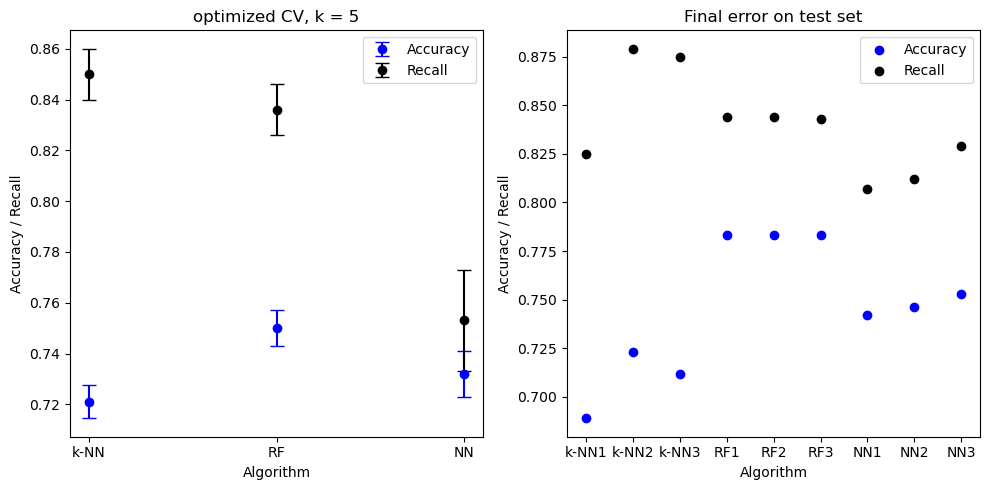

In [32]:
# Define the x-axis options
x = ['k-NN', 'RF', 'NN']
x2 = ['k-NN1','k-NN2', 'k-NN3','RF1','RF2', 'RF3', 'NN1','NN2','NN3']

# Define the y-axis values and their corresponding error bars
accuracies = [0.721, 0.750, 0.732]
accuracies2 = [0.689, 0.723, 0.712, 0.783, 0.783, 0.783, 0.742, 0.746, 0.753]
accuracy_errors = [0.0065, 0.007, 0.009]

recalls = [0.850, 0.836, 0.753]
recalls2 = [0.825, 0.879, 0.875, 0.844, 0.844, 0.843, 0.807, 0.812, 0.829]
recall_errors = [0.01, 0.01, 0.02]

# Create the figure and axis objects
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the first subplot with error bars
axs[0].errorbar(x, accuracies, yerr=accuracy_errors, fmt='o', color='blue', label='Accuracy', capsize=5)
axs[0].errorbar(x, recalls, yerr=recall_errors, fmt='o', color='black', label='Recall', capsize=5)
axs[0].set_title('optimized CV, k = 5')
axs[0].set_xlabel('Algorithm')
axs[0].set_ylabel('Accuracy / Recall')
axs[0].legend()

# Plot the first subplot with error bars
axs[1].scatter(x2, accuracies2, color='blue', label='Accuracy')
axs[1].scatter(x2, recalls2, color='black', label='Recall')
axs[1].set_title('Final error on test set')
axs[1].set_xlabel('Algorithm')
axs[1].set_ylabel('Accuracy / Recall')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.savefig('../results/final_comparison.png')
plt.show()
